In [1]:
%load_ext autoreload
%autoreload 2

# 总览
本次作业实现了 LyuTorch，其实现了一个 Tensor 类，这是一个 numpy.ndarray 的子类，在这个类中，作者手动实现了反向求导的功能.

Tensor 类支持对少数操作的反向求导，足以构造一个只包含全链接层的神经网络，方法十分简单.

```pycon
>>> import lyutorch as lyu
>>> a = lyu.tensor([[1, 2, 3]], requires_grad=True)
>>> c = a @ a.t()
>>> c = lyu.squeeze(c)
>>> c.backward()
>>> print(a.grad)
[[1. 2. 3.]]
```
上方的例子展示了如何使用 LyuTorch 进行反向求导，该例子计算了一个向量和自身的点乘. 这里的 c = a @ a.t() 是矩阵乘法，squeeze 是去掉长度为 1 的维度，backward 是反向求导.

以下是本次作业的主要代码：
## 读取数据

In [2]:
import struct
import numpy as np
import os

def read_file(folder_name: str) -> dict:
    """
    此函数从文件夹下读取所有形如idxn-ubyte的数据文件.
    :param folder_name: 文件夹字符串名.
    :return: 包含所有以文件名（不含后缀名）为key，ndarray为value的字典.
    """
    # 检查输入的文件夹是否存在，是否可读
    if not os.path.exists(folder_name):
        raise FileNotFoundError(f"Folder doesn't exists: {folder_name}")
    if not os.access(folder_name, os.R_OK):
        raise PermissionError(f"Folder not readable: {folder_name}")

    return_dict = {}
    for elements in os.scandir(folder_name):
        if elements.is_file():
            with open(elements.path, 'rb') as file:
                magic, size = struct.unpack('>II', file.read(8))
                dimension = magic & 0xFF  # 使用位运算获取存储数据的维数
                lengths = (size,) + struct.unpack(f">{dimension - 1}I",
                                                  file.read((dimension - 1) * 4))  #定义期望得到的ndarray结构
                data_temp = np.fromfile(file, dtype=np.uint8).reshape(lengths)  # 读取二进制文件并重整成正确的结构
                return_dict[os.path.splitext(elements.name)[0]] = data_temp
    return return_dict


# 读取数据
files = read_file('./dataset')

## 数据预处理
接下来我们对数据做最简单的预处理，首先将数据转化为我们自己实现的 Tensor 格式，之后将数据归一化到 $[-1, 1]$ 区间. 同时，我们将所有的 index 变成 one-hot 编码. 

In [3]:
import lyutorch as lyu
img_train = lyu.tensor(files['train-images'] * 2 / 255 - 1, dtype=np.float32)
img_test = lyu.tensor(files['t10k-images'] * 2 / 255 - 1, dtype=np.float32)
label_train = lyu.tensor(files['train-labels'], dtype=np.int8)
label_test = lyu.tensor(files['t10k-labels'], dtype=np.int8)

# 将数据变成 one-hot 编码
one_hot_matrix = np.eye(10)
label_train = lyu.tensor(one_hot_matrix[label_train.flatten()].reshape(-1,10).squeeze())
label_test = lyu.tensor(one_hot_matrix[label_test.flatten()].reshape(-1,10).squeeze())

print(label_train.shape)

(60000, 10)


## 网络结构
我们按照作业要求，使用三层线性神经网络对 MNIST 数据集进行预测，其中第一层和第二层的激活函数为 ReLU，第三层输出前的激活函数为 softmax.

In [4]:
import lyutorch.nn as nn


class Net(nn.Module):
    def __init__(self, hidden_layer_size: int = 64):
        super(Net, self).__init__()
        self._hidden = hidden_layer_size
        self.fc1 = lyu.tensor(np.random.normal(size=(28 * 28, hidden_layer_size)), requires_grad=True)
        self.fc2 = lyu.tensor(np.random.normal(size=(hidden_layer_size, 10)), requires_grad=True)
        self.bias1 = lyu.tensor(np.random.normal(size=(1, hidden_layer_size)), requires_grad=True)
        self.bias2 = lyu.tensor(np.random.normal(size=(1, 10)), requires_grad=True)
        self.add_parameter('fc1', self.fc1)
        self.add_parameter('fc2', self.fc2)
        self.add_parameter('bias1', self.bias1)
        self.add_parameter('bias2', self.bias2)
        self.target = lyu.tensor(np.eye(10))

    def forward(self, x):
        x = x @ self.fc1
        x = x + self.bias1
        x = nn.functional.relu(x)
        x = x @ self.fc2
        x = x + self.bias2
        x = nn.functional.softmax(x, self.target)
        return x

    def l2normalization(self):
        return (lyu.linalg.norm2(self.fc1, order=2) + lyu.linalg.norm2(self.fc2, order=2) + lyu.linalg.norm2(
            self.bias1, order=2) + lyu.linalg.norm2(self.bias2, order=2)) * lyu.tensor(
            1 / (28 * 28 * self._hidden + self._hidden * 10 + 10 + self._hidden))

    def grad_off(self):
        for key, value in self.parameters():
            value.requires_grad = False

    def grad_on(self):
        for key, value in self.parameters():
            value.requires_grad = True


img_train = img_train.reshape((60000, 28 * 28))
img_test = img_test.reshape((10000, 28 * 28))
# 创建网络实例
net = Net(hidden_layer_size=64)

## 实际训练

In [5]:
net = Net(hidden_layer_size=32)
sgd = nn.Optimizer(net.parameters(), lr=0.01)
sgd.zero_grad()
losses32 = []
BATCH_SIZE = 32
data = nn.DataLoader([img_train, label_train], shuffle=True, batch_size=BATCH_SIZE)


In [6]:
batch = 0
size = len(img_train)
for data_train in data:
    sgd.zero_grad()
    img = data_train[0]
    label = data_train[1]
    output = net(img)
    loss = nn.functional.cross_entropy_loss(output, label) + net.l2normalization()
    loss.backward()
    sgd.step()
    batch += 1
    losses32.append(loss.item())
    if batch % 100 == 0:
        print(f"loss: {loss:>7f}  [{batch * BATCH_SIZE:>5d}/{size:>5d}]")

loss: 9.854626  [ 3200/60000]
loss: 4.889562  [ 6400/60000]
loss: 4.030751  [ 9600/60000]
loss: 2.995701  [12800/60000]
loss: 2.154554  [16000/60000]
loss: 2.195130  [19200/60000]
loss: 2.369924  [22400/60000]
loss: 1.589147  [25600/60000]
loss: 2.514008  [28800/60000]
loss: 1.741504  [32000/60000]
loss: 1.593401  [35200/60000]
loss: 1.800871  [38400/60000]
loss: 1.673840  [41600/60000]
loss: 2.222689  [44800/60000]
loss: 1.761760  [48000/60000]


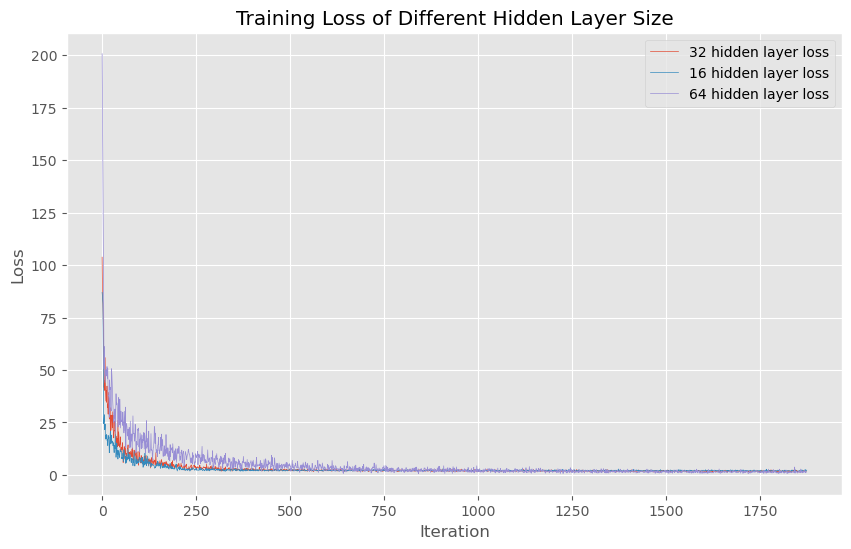

In [ ]:
import matplotlib.pyplot as plt
losses16 = np.load('losses16.npy')
losses64 = np.load('losses64.npy')
# 设置样式为 'ggplot'
plt.style.use('ggplot')

# 创建一个新的图像，并设置其大小
plt.figure(figsize=(10, 6))

# 绘制损失值，设置线的宽度为 1
plt.plot(losses32[:1876],label='32 hidden layer loss', linewidth=0.5)
plt.plot(losses16[:1876],label='16 hidden layer loss', linewidth=0.5)
plt.plot(losses64[:1876],label='64 hidden layer loss', linewidth=0.5)
# 设置图像的标题和坐标轴标签
plt.title('Training Loss on Different Hidden Layer Size')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# 显示图像

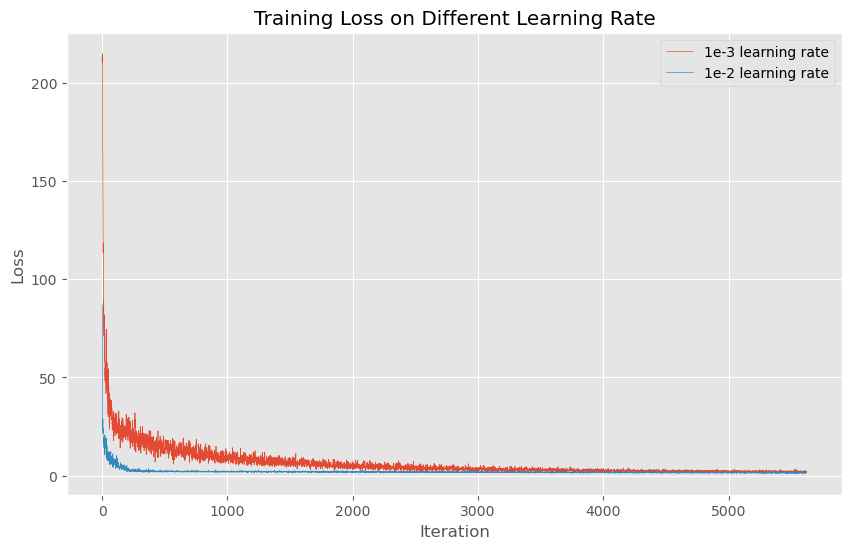

In [ ]:
import matplotlib.pyplot as plt
losses16_1e_3 = np.load('losses16-1e-3lr.npy')
# 设置样式为 'ggplot'
plt.style.use('ggplot')

# 创建一个新的图像，并设置其大小
plt.figure(figsize=(10, 6))

# 绘制损失值，设置线的宽度为 1
plt.plot(losses16_1e_3[:],label='1e-3 learning rate', linewidth=0.5)
plt.plot(losses16[:],label='1e-2 learning rate', linewidth=0.5)
# 设置图像的标题和坐标轴标签
plt.title('Training Loss on Different Learning Rate')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# 显示图像

In [ ]:
from sklearn.metrics import accuracy_score

with lyu.no_grad():
    output = net(img_test)
    output = output.argmax(dim=1)
    print(accuracy_score(output.numpy(), label_test.numpy().argmax(axis=1)))



AttributeError: module 'lyutorch.nn' has no attribute 'functional'